## Modelling

This note book explains the different steps in the machine learning model.For the trigger model we used a Regression model. First the model is trained on the full dataset to obtain the optimal features followed by hyper parameter tunning and model performance estimate using Nested Cross Validation.

* Nested Cross Validation for
    * Feature selection 
    * hyper parameter tunning 
* Performance metrics
* Baseline Models
 
### Regression 
At the end of this section we will obtain  the optimal Regression models and the performance estimates. Two models are implemented: Random Forest, XGBoost.First, the model is trained on the full dataset to obtain the optimal features followed by a model that obtains the performance estimate using Nested Cross Validation.

In [373]:
%load_ext autoreload
%autoreload 2

import numpy as np
import random
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import f1_score, precision_score, recall_score
from xgboost import XGBClassifier
import os
from sklearn.feature_selection import RFECV
import pandas as pd
from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    StratifiedKFold,
    KFold,
)
from sklearn.metrics import f1_score, mean_squared_error, mean_absolute_error
import numpy as np
from numpy.lib.function_base import average
import pandas as pd
import matplotlib.pyplot as plt

from xgboost.sklearn import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import (
    recall_score,
    f1_score,
    precision_score,
    confusion_matrix,
    make_scorer,
)
from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    StratifiedKFold,
    KFold,
)
from sklearn.feature_selection import SelectKBest, SequentialFeatureSelector
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
import importlib
import os
from sklearn.feature_selection import (
    SelectKBest,
    RFE,
    mutual_info_regression,
    f_regression,
    mutual_info_classif,
)
import eli5
from eli5.sklearn import PermutationImportance
from sklearn.inspection import permutation_importance
import xgboost as xgb
import random
import pickle
import openpyxl
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.feature_selection import RFE
from sklearn.feature_selection import RFECV
import pickle
from sklearn.linear_model import LinearRegression
import geopandas as gpd
import random
import importlib

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Define functions 

In [424]:
def splitting_train_test(df):

    # To save the train and test sets
    df_train_list = []
    df_test_list = []

    # List of typhoons that are to be used as a test set 
 
    typhoons_with_impact_data=list(np.unique(df.typhoon))

    for typhoon in typhoons_with_impact_data:
        if len(df[df["typhoon"] == typhoon]) >150:
            df_train_list.append(df[df["typhoon"] != typhoon])
            df_test_list.append(df[df["typhoon"] == typhoon])

    return df_train_list, df_test_list


def unweighted_random(y_train, y_test):
    options = y_train.value_counts(normalize=True)
    y_pred = random.choices(population=list(options.index), k=len(y_test))
    return y_pred

def weighted_random(y_train, y_test):
    options = y_train.value_counts()
    y_pred = random.choices(
        population=list(options.index), weights=list(options.values), k=len(y_test)
    )
    return y_pred

In [425]:
# Setting directory

wor_dir="/home/fbf/"
os.chdir(wor_dir)

cdir = os.getcwd()

In [426]:
# Import functions
from models.regression.rf_regression import (rf_regression_features,rf_regression_performance,)
from models.regression.xgb_regression import (xgb_regression_features,xgb_regression_performance,)


## Loading the data

In [427]:
combined_input_data=pd.read_csv("data/model_input/combined_input_data.csv")

typhoons_with_impact_data=['bopha2012', 'conson2010', 'durian2006', 'fengshen2008',
       'fung-wong2014', 'goni2015', 'goni2020', 'hagupit2014',
       'haima2016', 'haiyan2013', 'jangmi2014', 'kalmaegi2014',
       'kammuri2019', 'ketsana2009', 'koppu2015', 'krosa2013',
       'linfa2015', 'lingling2014', 'mangkhut2018', 'mekkhala2015',
       'melor2015', 'meranti2016', 'molave2020', 'mujigae2015',
       'nakri2019', 'nari2013', 'nesat2011', 'nock-ten2016', 'noul2015',
       'phanfone2019', 'rammasun2014', 'sarika2016', 'saudel2020',
       'tokage2016', 'trami2013', 'usagi2013', 'utor2013', 'vamco2020',
       'vongfong2020', 'yutu2018']


combined_input_data=combined_input_data[combined_input_data.typhoon.isin(typhoons_with_impact_data)]

Replace missing values with zero for records with low windspeed and rainfall \n

<math xmlns="http://www.w3.org/1998/Math/MathML" display="block">
  <mfrac>
    <msup>
      <mi>V</mi>
      <mn>2</mn>
    </msup>
    <mrow>
      <mo stretchy="false">(</mo>
      <mn>V_max</mn>
      <msup>
        <mo stretchy="false">)</mo>
        <mn>2</mn>
      </msup>
    </mrow>
  </mfrac>
  <mo>+</mo>
  <mfrac>
    <msup>
      <mi>rain</mi>
      <mn>2</mn>
    </msup>
    <mrow>
      <mo stretchy="false">(</mo>
      <mn>rain_max</mn>
      <msup>
        <mo stretchy="false">)</mo>
        <mn>2</mn>
      </msup>
    </mrow>
  </mfrac>
  <mo>=</mo>
  <mn>1</mn>
</math>

In [428]:
def set_zeros(x):
    x_max = 25
    y_max = 50
    
    v_max = x[0]
    rainfall_max = x[1]
    damage = x[2]
    if pd.notnull(damage):
        value = damage
    elif v_max > x_max or rainfall_max > y_max:
        value =damage
    elif (v_max < np.sqrt((1- (rainfall_max**2/y_max ** 2))*x_max ** 2)):
        value = 0
    #elif ((v_max < x_max)  and  (rainfall_max_6h < y_max) ):
    #elif (v_max < x_max ):
    #value = 0
    else:
        value = np.nan

    return value
combined_input_data["DAM_perc_dmg"] = combined_input_data[["HAZ_v_max", "HAZ_rainfall_Total", "DAM_perc_dmg"]].apply(set_zeros, axis="columns")

In [429]:
combined_input_data = combined_input_data[combined_input_data['DAM_perc_dmg'].notnull()]
combined_input_data["DAM_perc_dmg"]

0        3.632568
4        0.272109
9        0.000000
10       1.053556
11      39.364371
          ...    
9067     0.000000
9087     0.000000
9097     0.634468
9098     0.070061
9102     1.129944
Name: DAM_perc_dmg, Length: 3428, dtype: float64

### Adtional variables 

In [431]:
def cubeic(x):
    #x=float(x)
    value=x*x*x
    return value


#combined_input_data["HAZ_v_max_3"] = combined_input_data.apply(lambda x: cubeic(x["HAZ_v_max"]), axis=1).values

combined_input_data['HAZ_v_max_3']=combined_input_data['HAZ_v_max'].apply(lambda x: x*x*x) 

In [432]:
combined_input_data =combined_input_data.filter(['typhoon','HAZ_rainfall_Total', 
        'HAZ_rainfall_max_6h',
        'HAZ_rainfall_max_24h',
        'HAZ_v_max',
        'HAZ_v_max_3',
        'HAZ_dis_track_min',
        'GEN_landslide_per',
        'GEN_stormsurge_per',
        'GEN_Bu_p_inSSA', 
        'GEN_Bu_p_LS', 
        'GEN_Red_per_LSbldg',
        'GEN_Or_per_LSblg', 
        'GEN_Yel_per_LSSAb', 
        'GEN_RED_per_SSAbldg',
        'GEN_OR_per_SSAbldg',
        'GEN_Yellow_per_LSbl',
        'TOP_mean_slope',
        'TOP_mean_elevation_m', 
        'TOP_ruggedness_stdev', 
        'TOP_mean_ruggedness',
        'TOP_slope_stdev', 
        'VUL_poverty_perc',
        'GEN_with_coast',
        'GEN_coast_length', 
        'VUL_Housing_Units',
        'VUL_StrongRoof_StrongWall', 
        'VUL_StrongRoof_LightWall',
        'VUL_StrongRoof_SalvageWall', 
        'VUL_LightRoof_StrongWall',
        'VUL_LightRoof_LightWall', 
        'VUL_LightRoof_SalvageWall',
        'VUL_SalvagedRoof_StrongWall',
        'VUL_SalvagedRoof_LightWall',
        'VUL_SalvagedRoof_SalvageWall', 
        'VUL_vulnerable_groups',
        'VUL_pantawid_pamilya_beneficiary', 
        'DAM_perc_dmg'])

In [433]:
features =['HAZ_rainfall_Total', 
        'HAZ_rainfall_max_6h',
        'HAZ_rainfall_max_24h',
        'HAZ_v_max',
        'HAZ_v_max_3',
        'HAZ_dis_track_min',
        'GEN_landslide_per',
        'GEN_stormsurge_per',
        'GEN_Bu_p_inSSA', 
        'GEN_Bu_p_LS', 
        'GEN_Red_per_LSbldg',
        'GEN_Or_per_LSblg', 
        'GEN_Yel_per_LSSAb', 
        'GEN_RED_per_SSAbldg',
        'GEN_OR_per_SSAbldg',
        'GEN_Yellow_per_LSbl',
        'TOP_mean_slope',
        'TOP_mean_elevation_m', 
        'TOP_ruggedness_stdev', 
        'TOP_mean_ruggedness',
        'TOP_slope_stdev', 
        'VUL_poverty_perc',
        'GEN_with_coast',
        'GEN_coast_length', 
        'VUL_Housing_Units',
        'VUL_StrongRoof_StrongWall', 
        'VUL_StrongRoof_LightWall',
        'VUL_StrongRoof_SalvageWall', 
        'VUL_LightRoof_StrongWall',
        'VUL_LightRoof_LightWall', 
        'VUL_LightRoof_SalvageWall',
        'VUL_SalvagedRoof_StrongWall',
        'VUL_SalvagedRoof_LightWall',
        'VUL_SalvagedRoof_SalvageWall', 
        'VUL_vulnerable_groups',
        'VUL_pantawid_pamilya_beneficiary']

#### Random Forest 

In [434]:
# Full dataset for feature selection

df=combined_input_data.dropna()
 
#combined_input_data = combined_input_data[combined_input_data['DAM_perc_dmg'].notnull()]
X = df[features]
y = df["DAM_perc_dmg"]

# Setting the train and the test sets for obtaining performance estimate
df_train_list, df_test_list = splitting_train_test(df)

### Feature selection

Feature Selection is an important step in devloping a machine learning model.Data features used to train a machine learning model will influence model performance,less important features can have a negative impact on model performance.
Feature Selection aims to solve the problem of identifying relevant features from a dataset by removing the less important features, which have little/no contribution to our target variable. Feature selection helps to achieve better model accuracy.

There are different techniques for feature selection. For this research we used Recursive feature elimination (RFE),which is a feature selection method that fits a model and removes the weakest feature (or features) until the specified number of features is reached. Features are ranked by the model’s coef_ or feature_importances_ attributes, and by recursively eliminating a small number of features per loop, RFE attempts to eliminate dependencies and collinearity that may exist in the model.
To find the optimal number of features we applied cross-validation with RFE on the entire data set. 


In [ ]:
#%% Setting input varialbes
rf_search_space = [
    {
        "estimator__n_estimators": [100, 150],
        "estimator__max_depth": [20, None],
        "estimator__min_samples_split": [4, 5, 8],
        "estimator__min_samples_leaf":[1, 3, 5],
    }
]

(
    selected_features_rf_regr,
    selected_params_rf_regr_full,
) = rf_regression_features(
    X=X,
    y=y,
    features=features,
    search_space=rf_search_space,
    min_features_to_select=1,
    cv_splits=3,
    GS_score="neg_root_mean_squared_error",
    GS_randomized=False,
    GS_n_iter=10,
    verbose=10,
)

print(
    f"Number of selected features RF Regression {len(selected_features_rf_regr)}"
)
print(f"Selected features RF Regression: {selected_features_rf_regr}")
print(f"Selected Parameters RF Regression: {selected_params_rf_regr_full}")

In [435]:
# Based on output previous cell
selected_features_rf_regr=[
    'HAZ_rainfall_Total', 
    'HAZ_rainfall_max_6h',
    'HAZ_rainfall_max_24h',
    'HAZ_v_max', 
    'HAZ_v_max_3',
    'HAZ_dis_track_min',
    'GEN_landslide_per', 
    'GEN_stormsurge_per',
    'GEN_Bu_p_inSSA', 
    'GEN_Bu_p_LS',
    'GEN_Red_per_LSbldg',
    'GEN_Yel_per_LSSAb',
    'GEN_RED_per_SSAbldg', 
    'GEN_OR_per_SSAbldg',
    'TOP_mean_slope', 
    'TOP_mean_elevation_m', 
    'TOP_ruggedness_stdev', 
    'TOP_mean_ruggedness', 
    'TOP_slope_stdev', 
    'VUL_poverty_perc', 
    'GEN_coast_length',
    'VUL_Housing_Units', 
    'VUL_StrongRoof_StrongWall', 
    'VUL_StrongRoof_LightWall',
    'VUL_StrongRoof_SalvageWall',
    'VUL_LightRoof_LightWall', 
    'VUL_LightRoof_SalvageWall', 
    'VUL_SalvagedRoof_StrongWall',
    'VUL_SalvagedRoof_LightWall', 
    'VUL_SalvagedRoof_SalvageWall',
    'VUL_vulnerable_groups', 
    'VUL_pantawid_pamilya_beneficiary'
]

In [ ]:
#xg_reg = xgb.train(params=params, dtrain=data_dmatrix, num_boost_round=10)
#xgb.plot_importance(xg_reg)
#plt.rcParams['figure.figsize'] = [5, 5]
#plt.show()

### Hyper Parameter optimization  

Machine learning models have hyperparameters that you must set in order to customize the model to your dataset. Often the general effects of hyperparameters on a model are known, but how to best set a hyperparameter and combinations of interacting hyperparameters for a given dataset is challenging. There are often general rules of thumb for configuring hyperparameters. A better approach is to objectively search different values for model hyperparameters and choose a subset that results in a model that achieves the best performance on a given dataset. This is called hyperparameter optimization or hyperparameter tuning and is available in the scikit-learn Python machine learning library. [Source](https://machinelearningmastery.com/) 




Hyperparameters are essentila components for machine learning algorithms, they control behaviour and performance of a machine learning model. For a learning algorithm optimal hyperparameter selection, hyperparameter tuning is esstil first step as it helps to achive best model performance on the data set with a reasonable amount of time.[source](https://www.sciencedirect.com/science/article/pii/S1674862X19300047)

To reduce the bias in performance evaluation, model selection should be treated as an integral part of the model fitting procedure, and should be conducted independently in each trial in order to prevent selection bias.[source](https://www.jmlr.org/papers/v11/cawley10a.html)

There are different techniques for Hyperparameters, for this research we used neasted K-fold cross validation technique. 
Nested cross-validation uses inner and outer loops when optimizing the hyperparameters of a model on a dataset, and when comparing and selecting a model for the dataset. This reduced biased evaluation of model performance as different dataset are used to for hyperparameter tunning and model selection.

In our implementation of nested CV the outer loop iterates over typhoon events in our datasets, holiding data for one typhoon for test set and assigning the remaining data as training set. In the inner loop a k-fold CV is applied on the training dataset



In [ ]:
#%% Setting input varialbes
rf_search_space = [
    {
        "rf__n_estimators": [200],
        "rf__max_depth": [18],
        "rf__min_samples_split": [8],
        "rf__min_samples_leaf": [1, 3],
    }
]

df_predicted_rf_regr, selected_params_rf_regr = rf_regression_performance(
    df_train_list=df_train_list,
    df_test_list=df_test_list,
    y_var='DAM_perc_dmg',
    features=selected_features_rf_regr,#selected_features_rf_regr,
    search_space=rf_search_space,
    cv_splits=5,
    GS_score="neg_root_mean_squared_error",
    GS_randomized=False,
    GS_n_iter=10,
    verbose=10,
)

In [437]:
#Selected_Parameters={'rf__max_depth': 22, 
# 'rf__min_samples_leaf': 3,
# 'rf__min_samples_split': 2,
# 'rf__n_estimators': 100}

 


file_name = "models/output/v1/selected_params_rf_regr1.p"
path = os.path.join(cdir, file_name)
pickle.dump(selected_params_rf_regr, open(path, "wb"))

file_name = "models/output/v1/df_predicted_rf_regr1.csv"
path = os.path.join(cdir, file_name)
df_predicted_rf_regr.to_csv(path)

#df_predicted_rf_regr=pd.read_csv(path)

C:\Users\ATEKLE~1\AppData\Local\Temp/ipykernel_27196/13759082.py:11: ResourceWarning: unclosed file <_io.BufferedWriter name='C:\\Users\\ATeklesadik\\OneDrive - Rode Kruis\\Documents\\documents\\Typhoon-Impact-based-forecasting-model\\IBF-typhoon-model\\models\\output\\v1\\selected_params_rf_regr1.p'>
  pickle.dump(selected_params_rf_regr, open(path, "wb"))


In [ ]:
combined_input_data = combined_input_data[combined_input_data['DAM_perc_dmg'].notnull()] 

### XGBoost Regression 
Obtaining the optimal model

In [220]:
# Full dataset for feature selection



combined_input_data = combined_input_data[combined_input_data['DAM_perc_dmg'].notnull()]

X = combined_input_data[features]
y = combined_input_data["DAM_perc_dmg"]

# Setting the train and the test sets for obtaining performance estimate
df_train_list, df_test_list = splitting_train_test(combined_input_data)


 

In [ ]:
#learning_rate: step size shrinkage used to prevent overfitting. Range is [0,1]
#max_depth: determines how deeply each tree is allowed to grow during any boosting round.
#subsample: percentage of samples used per tree. Low value can lead to underfitting.
#colsample_bytree: percentage of features used per tree. High value can lead to overfitting.
#n_estimators: number of trees you want to build.

xgb_search_space = [
    {
        "estimator__learning_rate": [0.1, 0.5, 1],
        "estimator__gamma": [0.1, 0.5, 2],
        "estimator__max_depth": [6, 8],
        "estimator__reg_lambda": [0.001, 0.1, 1],
        "estimator__n_estimators": [100, 150,200],
        "estimator__colsample_bytree": [0.5, 0.7],
    }
]

selected_features_xgb_regr, selected_params_xgb_regr_full = xgb_regression_features(
    X=X,
    y=y,
    features=features,
    search_space=xgb_search_space,
    min_features_to_select=1,
    cv_splits=5,
    GS_score="neg_root_mean_squared_error",
    objective="reg:squarederror",
    GS_randomized=True,
    GS_n_iter=400,
    verbose=10,
)


print(f"Number of selected features XGBoost Regression {len(selected_features_xgb_regr)}")
print(f"Selected features XGBoost Regression: {selected_features_xgb_regr}")
print(f"Selected Parameters XGBoost Regression: {selected_params_xgb_regr_full}")



### Obtaining performance estimate

In [19]:
# Setting the selected features for XGB based on the above cell

selected_features_xgb_regr = ['HAZ_rainfall_Total',
 'HAZ_v_max',
 'HAZ_dis_track_min',
 'GEN_landslide_per',
 'TOP_mean_elevation_m',
 'TOP_mean_ruggedness',
 'VUL_Housing_Units',
 'VUL_StrongRoof_StrongWall',
 'VUL_StrongRoof_LightWall',
 'VUL_LightRoof_StrongWall',
 'VUL_vulnerable_groups',
 'VUL_pantawid_pamilya_beneficiary']

selected_params_xgb_regr_full={'estimator__reg_lambda': 0.001,
 'estimator__n_estimators': 200,
 'estimator__max_depth': 6,
 'estimator__learning_rate': 0.1,
 'estimator__gamma': 0.1,
 'estimator__colsample_bytree': 0.5}

### parameter optimization first based on selected model features

In [ ]:
xgb_search_space = [
    {
        "xgb__learning_rate": [0.03],
        "xgb__gamma": [0.1],
        "xgb__max_depth": [6,8],
        "xgb__reg_lambda": [0.001],
        "xgb__n_estimators": [50],
        "xgb__colsample_bytree": [0.7],
    }
]



df_predicted_xgb_regr, selected_params_xgb_regr = xgb_regression_performance(
    df_train_list=df_train_list,
    df_test_list=df_test_list,
    y_var='DAM_perc_dmg',
    features=features,#selected_features_xgb_regr,
    search_space=xgb_search_space,
    cv_splits=5,
    objective="reg:squarederror",
    GS_score="neg_root_mean_squared_error",
    GS_randomized=True,
    GS_n_iter=500,
    verbose=10,
)


In [439]:
file_name = "models/output/v1/selected_params_xgb_regr.p"
path = os.path.join(cdir, file_name)
pickle.dump(selected_params_xgb_regr, open(path, "wb"))

file_name = "models/output/v1/df_predicted_xgb_regr.csv"
path = os.path.join(cdir, file_name)
df_predicted_xgb_regr.to_csv(path)

C:\Users\ATEKLE~1\AppData\Local\Temp/ipykernel_27196/359379357.py:3: ResourceWarning: unclosed file <_io.BufferedWriter name='C:\\Users\\ATeklesadik\\OneDrive - Rode Kruis\\Documents\\documents\\Typhoon-Impact-based-forecasting-model\\IBF-typhoon-model\\models\\output\\v1\\selected_params_xgb_regr.p'>
  pickle.dump(selected_params_xgb_regr, open(path, "wb"))


### Baseline models

The Baseline model is based on this information (check how to relate result) 


https://ndrrmc.gov.ph/attachments/article/1509/Component_4_Tropical_Cyclone_Severe_Wind_Technical_Report_-_Final_Draft_by_GA_and_PAGASA.pdf

In [440]:
file_name = "models/baseline/BASILE_MODEL.xlsx"

path = os.path.join(wor_dir, file_name)
VUL_StrongRoof_StrongWall = pd.read_excel(path, sheet_name="C1_M", engine="openpyxl")  #DAM_Strong.Roof.Strong.Wall 80 
VUL_StrongRoof_LightWall = pd.read_excel(path, sheet_name="CHB_L_W", engine="openpyxl") #DAM_Strong.Roof.Light.Wall 80 
VUL_StrongRoof_SalvageWall = pd.read_excel(path, sheet_name="CWS_L_W", engine="openpyxl") #DAM_Strong.Roof.Salvage.Wall  80
VUL_LightRoof_StrongWall = pd.read_excel(path, sheet_name="C1_L_S", engine="openpyxl") #DAM_Light.Roof.Strong.Wall 80
VUL_LightRoof_LightWall = pd.read_excel(path, sheet_name="W1_L", engine="openpyxl") #DAM_Light.Roof.Light.Wall 80
VUL_SalvagedRoof_LightWall = pd.read_excel(path, sheet_name="W3_L", engine="openpyxl")#DAM_Salvaged.Roof.Light.Wall 50
VUL_SalvagedRoof_SalvageWall = pd.read_excel(path, sheet_name="N_L", engine="openpyxl")#DAM_Salvaged.Roof.Salvaged.Wall 80

df_damagecurve=[VUL_StrongRoof_StrongWall,
VUL_StrongRoof_LightWall ,
VUL_StrongRoof_SalvageWall ,
VUL_LightRoof_StrongWall ,
VUL_LightRoof_LightWall,
VUL_SalvagedRoof_LightWall ,
VUL_SalvagedRoof_SalvageWall ]

vul_list=[
    'VUL_StrongRoof_StrongWall',
    'VUL_StrongRoof_LightWall' ,
    'VUL_StrongRoof_SalvageWall' ,
    'VUL_LightRoof_StrongWall' ,
    'VUL_LightRoof_LightWall',
    'VUL_SalvagedRoof_LightWall' ,
    'VUL_SalvagedRoof_SalvageWall' ]

df_damagecurve=[df.rename(columns={"Unnamed: 0": "damage_ratio", "Unnamed: 1": "wind_kmh"}) for df in df_damagecurve]

from sklearn.preprocessing import PolynomialFeatures
poly_reg = PolynomialFeatures(degree=5)

train = combined_input_data
input_variable = "HAZ_v_max"
x_train = 3.6*train[input_variable].values.reshape(-1, 1)
y_train = 100*train["DAM_perc_dmg"].values.reshape(-1, 1)


train_dm={}
train_dml=[]

for j in range(len(df_damagecurve)):
    train_ = df_damagecurve[j]
    x_train1 = train_['wind_kmh'].values.reshape(-1, 1)
    y_train1 = train_["damage_ratio"].values.reshape(-1, 1)
    model = LinearRegression()        
    lr_fitted= model.fit(poly_reg.fit_transform(x_train1), y_train1) 
    y_pred_train =lr_fitted.predict(poly_reg.fit_transform(x_train))


    y_pred_train =y_pred_train.flatten()* train[vul_list[j]].values
    train_dm[j]=y_pred_train
for value in (zip(*list(train_dm.values()))):
       train_dml.append(sum(value))
        
train["predicted"]=train_dml

def wind_check(x):
    v_max = x[0]  
    damage = x[1]
    if v_max < 22: ### remove prediction below windspeed 80km/h 
        value = 0
    elif damage>100:
        value = 100
    else:
        value = damage
    return value

df_predicted_damagecurve = pd.DataFrame({"typhoon": train["typhoon"], "actual": train["DAM_perc_dmg"].values} )

df_predicted_damagecurve["predicted"] = train[["predicted","HAZ_v_max"]].apply(wind_check, axis="columns")

file_name = "models/output/v1/df_predicted_damagecurve.csv"
path = os.path.join(cdir, file_name)
df_predicted_damagecurve.to_csv(path)

In [441]:
# Predict the average
df_predicted_mean = pd.DataFrame(columns=["typhoon", "actual", "predicted"])

for i in range(len(df_train_list)):

    train = df_train_list[i]
    test = df_test_list[i]

    y_train = train["DAM_perc_dmg"]
    y_test = test["DAM_perc_dmg"]

    y_test_pred = [np.mean(y_train)] * len(y_test)

    df_predicted_temp = pd.DataFrame(
        {"typhoon": test["typhoon"], "actual": y_test, "predicted": y_test_pred}
    )

    df_predicted_mean = pd.concat([df_predicted_mean, df_predicted_temp])

file_name = "models/output/v1/df_predicted_mean.csv"
path = os.path.join(cdir, file_name)
df_predicted_mean.to_csv(path)

In [450]:
# Simle Linear Regression with Wind Speed
input_variable = "HAZ_v_max"
df_predicted_lr = pd.DataFrame(columns=["typhoon", "actual", "predicted"])

for i in range(len(df_train_list)):

    train = df_train_list[i]
    test = df_test_list[i]

    x_train = train[input_variable].values.reshape(-1, 1)
    y_train = train["DAM_perc_dmg"].values.reshape(-1, 1)

    x_test = test[input_variable].values.reshape(-1, 1)
    y_test = test["DAM_perc_dmg"]

    model = LinearRegression()
    lr_fitted = model.fit(x_train, y_train)

    y_pred_train = lr_fitted.predict(x_train)
    y_pred_test = lr_fitted.predict(x_test)
    y_pred_test = y_pred_test.tolist()
    y_pred_test = [val for sublist in y_pred_test for val in sublist]

    df_predicted_temp = pd.DataFrame(
        {"typhoon": test["typhoon"], "actual": y_test, "predicted": y_pred_test}
    )

    df_predicted_lr = pd.concat([df_predicted_lr, df_predicted_temp])
    
file_name = "models/output/v1/df_predicted_lr.csv"
path = os.path.join(cdir, file_name)
df_predicted_lr.to_csv(path)

### Training the optimal model

In [444]:
rf = RandomForestRegressor(max_depth=18,
                           min_samples_leaf=5, 
                           min_samples_split=8, 
                           n_estimators=250,)


#Selected_Parameters={'rf__max_depth': 22, 
# 'rf__min_samples_leaf': 3,
# 'rf__min_samples_split': 2,
# 'rf__n_estimators': 100}



rf_fitted = rf.fit(X, y)

file_name = "models/saved_models/trained_regr_rf.sav"
path = os.path.join(wor_dir, file_name)
pickle.dump(rf_fitted, open(path, "wb"))

C:\Users\ATEKLE~1\AppData\Local\Temp/ipykernel_27196/2912949275.py:18: ResourceWarning: unclosed file <_io.BufferedWriter name='C:\\Users\\ATeklesadik\\OneDrive - Rode Kruis\\Documents\\documents\\Typhoon-Impact-based-forecasting-model\\IBF-typhoon-model\\models\\saved_models\\trained_regr_rf.sav'>
  pickle.dump(rf_fitted, open(path, "wb"))


In [445]:
# load
rf_model_loaded = pickle.load(open(path, "rb"))

C:\Users\ATEKLE~1\AppData\Local\Temp/ipykernel_27196/1591229010.py:2: ResourceWarning: unclosed file <_io.BufferedReader name='C:\\Users\\ATeklesadik\\OneDrive - Rode Kruis\\Documents\\documents\\Typhoon-Impact-based-forecasting-model\\IBF-typhoon-model\\models\\saved_models\\trained_regr_rf.sav'>
  rf_model_loaded = pickle.load(open(path, "rb"))


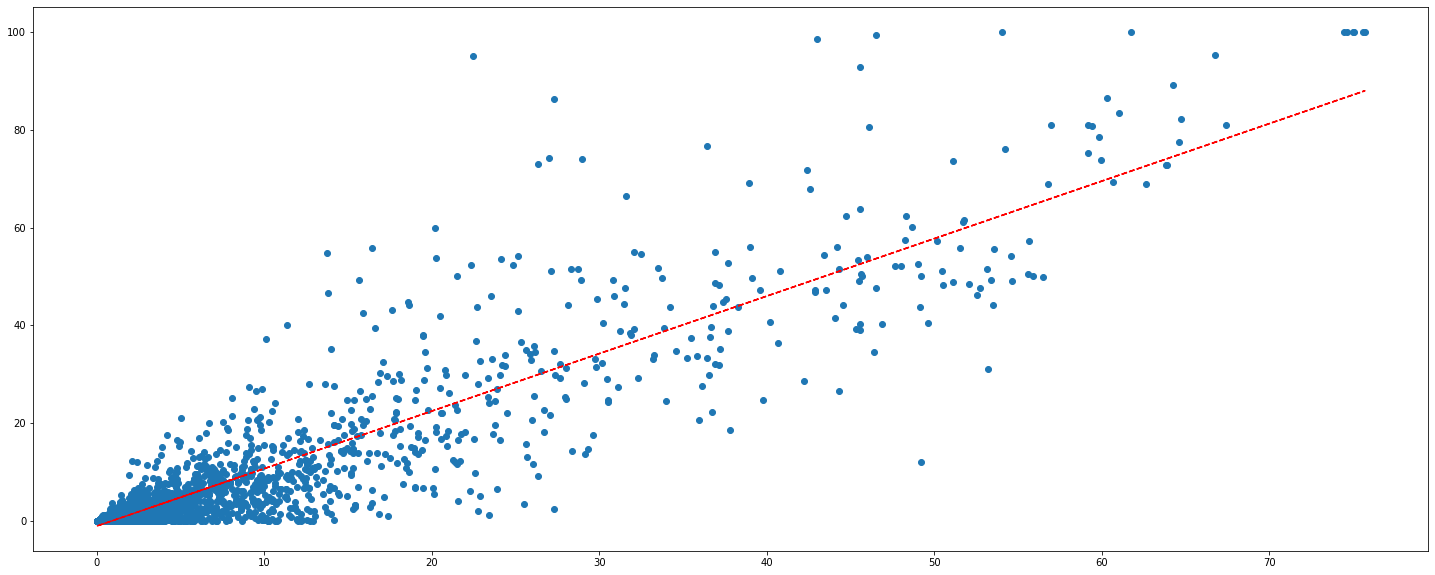

2.5560112861742557

In [446]:
df_f=pd.DataFrame()
df_f['y2']=rf_model_loaded.predict(X)
df_f['y']=y.values
x = df_f['y2']
y = df_f['y']

from sklearn.metrics import mean_absolute_error
plt.scatter(x, y)

z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x,p(x),"r--")
plt.show()
mean_absolute_error(x, y)

In [ ]:
## XGboost 

In [447]:
# create an xgboost regression model
xg = XGBRegressor(eta=0.004,
                gamma=0.1,
                learning_rate= 0.03,
                max_depth= 8,
                min_child_weight=3,
                alpha= 20,
                n_estimators=50,
                subsample=0.7,
                colsample_bytree=0.7)

xg_fitted = xg.fit(X, y)

file_name = "models/saved_models/trained_regr_xg.sav"
path = os.path.join(wor_dir, file_name)
pickle.dump(xg_fitted, open(path, "wb"))  


C:\Users\ATEKLE~1\AppData\Local\Temp/ipykernel_27196/573272359.py:16: ResourceWarning: unclosed file <_io.BufferedWriter name='C:\\Users\\ATeklesadik\\OneDrive - Rode Kruis\\Documents\\documents\\Typhoon-Impact-based-forecasting-model\\IBF-typhoon-model\\models\\saved_models\\trained_regr_xg.sav'>
  pickle.dump(xg_fitted, open(path, "wb"))


### load model 

In [448]:

# load
xgb_model_loaded = pickle.load(open(path, "rb"))

C:\Users\ATEKLE~1\AppData\Local\Temp/ipykernel_27196/3317275933.py:2: ResourceWarning: unclosed file <_io.BufferedReader name='C:\\Users\\ATeklesadik\\OneDrive - Rode Kruis\\Documents\\documents\\Typhoon-Impact-based-forecasting-model\\IBF-typhoon-model\\models\\saved_models\\trained_regr_xg.sav'>
  xgb_model_loaded = pickle.load(open(path, "rb"))


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


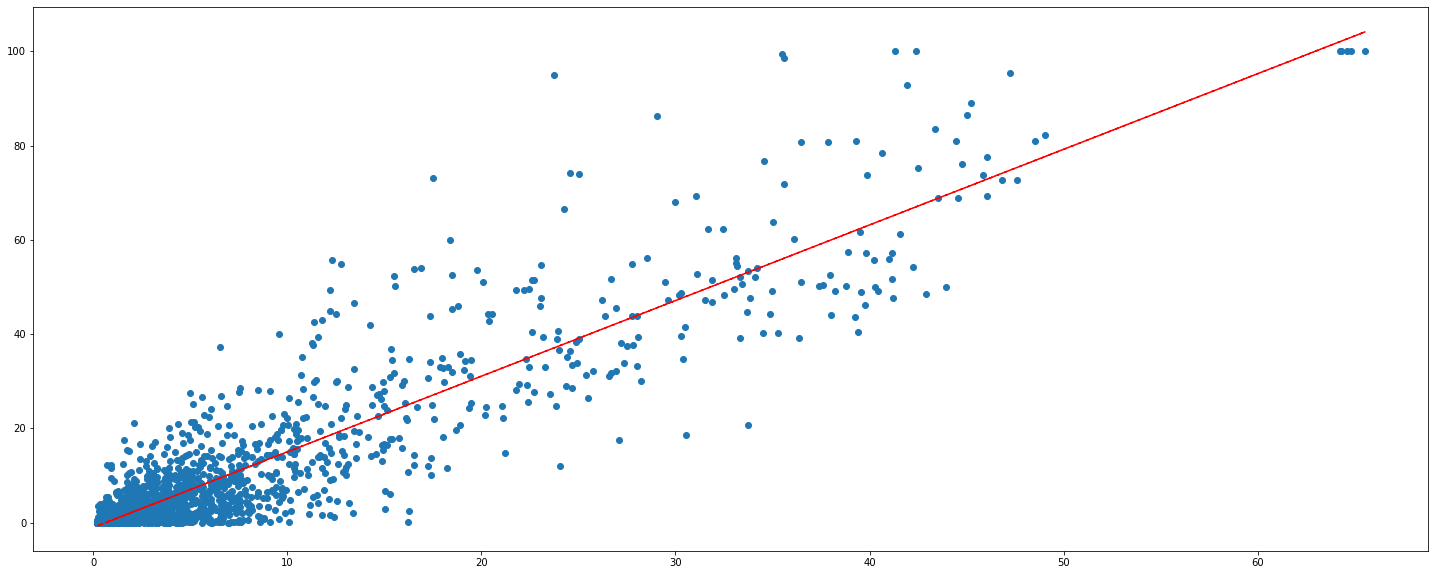

3.018205672812931

In [449]:
df_f=pd.DataFrame()
df_f['y2']=xgb_model_loaded.predict(X)
df_f['y']=y.values
x = df_f['y2']
y = df_f['y']

from sklearn.metrics import mean_absolute_error
plt.scatter(x, y)

z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x,p(x),"r--")
plt.show()
mean_absolute_error(x, y)

### Extra information on model parameter Tunning 

<AxesSubplot:>

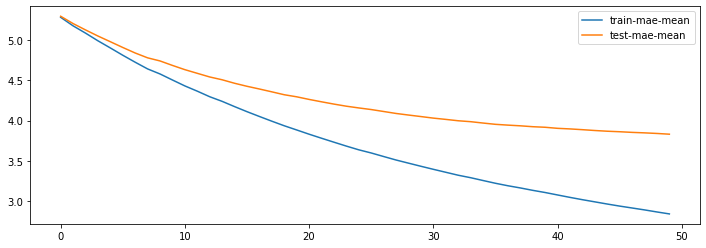

In [410]:
# fit a final xgboost model on the housing dataset and make a prediction
from numpy import asarray
from pandas import read_csv
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
import numpy

        
data_dmatrix = xgb.DMatrix(data=X,label=y)



cv_results = xgb.cv(dtrain=data_dmatrix,
                    params=params,
                    nfold=5,
                    num_boost_round=50,
                    #early_stopping_rounds=10,
                    metrics="mae",
                    as_pandas=True,
                    seed=123)

 
cv_results['id']=cv_results.index
df=cv_results.filter(['train-mae-mean','test-mae-mean'])
fig, axs = plt.subplots(figsize=(12, 4))

df.plot.line(ax=axs)

In [411]:
df

,train-mae-mean,test-mae-mean
0,5.279998,5.292797
1,5.173980,5.202274
2,5.084126,5.123594
3,4.988893,5.048012
4,4.900338,4.977403
5,4.809921,4.906150
6,4.723523,4.837747
7,4.640562,4.777812
8,4.578064,4.739257
9,4.503392,4.683845


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

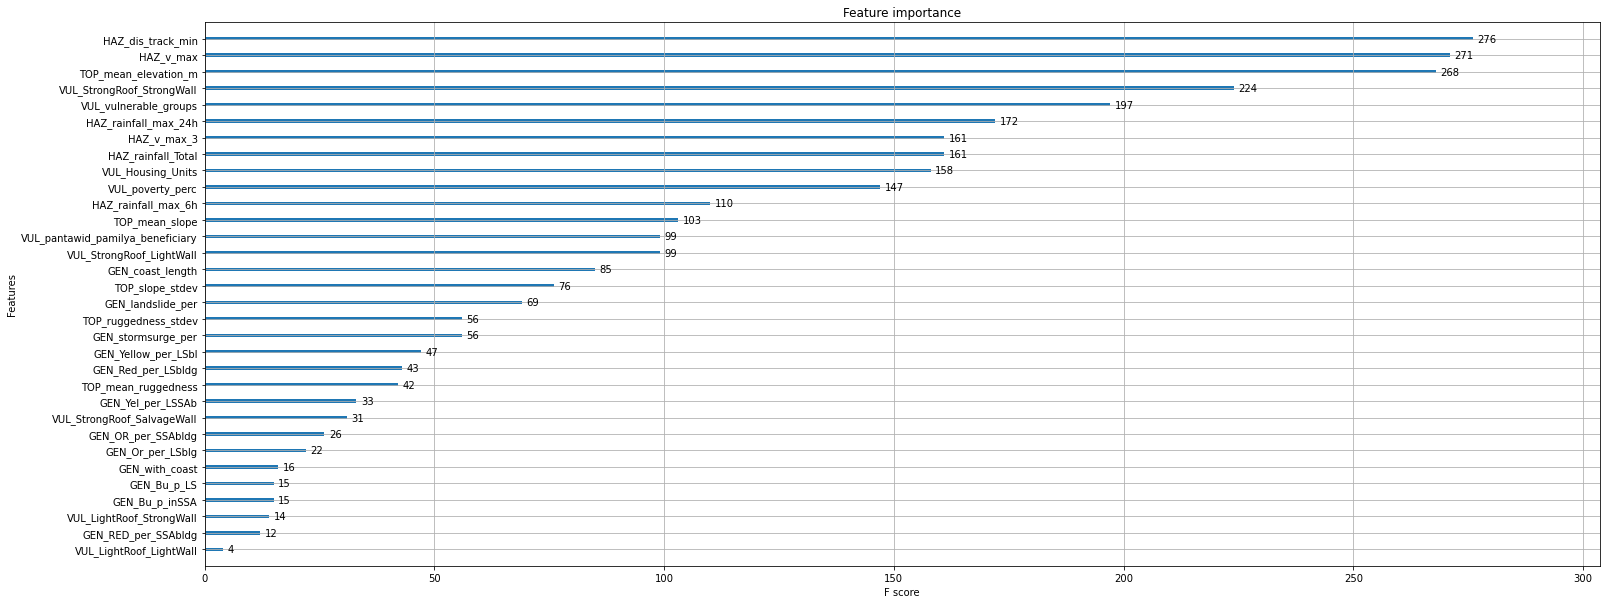

In [409]:
xgb.plot_importance(model_xgb)
#plt.rcParams['figure.figsize'] = [25, 10]
#plt.show()